<a href="https://colab.research.google.com/github/seharnazeer/Python--projects/blob/main/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from collections import Counter
import numpy as np
from sklearn.datasets import load_iris
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
class Node:
    def __init__(self, feature=None, value=None, results=None, true_branch=None, false_branch=None):
        self.feature = feature  # Feature to split on
        self.value = value      # Value of the feature to split on
        self.results = results  # Stores class labels if node is a leaf node
        self.true_branch = true_branch  # Branch for values that are True for the feature
        self.false_branch = false_branch  # Branch for values that are False for the feature


In [3]:
def entropy(data):
    counts = np.bincount(data)
    probabilities = counts / len(data)
    entropy = -np.sum([p * np.log2(p) for p in probabilities if p > 0])
    return entropy


In [4]:
def split_data(X, y, feature, value):
    true_indices = np.where(X[:, feature] <= value)[0]
    false_indices = np.where(X[:, feature] > value)[0]
    true_X, true_y = X[true_indices], y[true_indices]
    false_X, false_y = X[false_indices], y[false_indices]
    return true_X, true_y, false_X, false_y


In [5]:
def build_tree(X, y, max_depth=None, current_depth=0):  # Add max_depth and current_depth parameters
    y = y.ravel()
    if len(set(y)) == 1 or (max_depth is not None and current_depth >= max_depth): # Check for max_depth condition
        return Node(results=y[0])

    best_gain = 0
    best_criteria = None
    best_sets = None
    n_features = X.shape[1]

    current_entropy = entropy(y)

    for feature in range(n_features):
        feature_values = set(X[:, feature])
        for value in feature_values:
            true_X, true_y, false_X, false_y = split_data(X, y, feature, value)
            true_entropy = entropy(true_y)
            false_entropy = entropy(false_y)
            p = len(true_y) / len(y)
            gain = current_entropy - p * true_entropy - (1 - p) * false_entropy

            if gain > best_gain:
                best_gain = gain
                best_criteria = (feature, value)
                best_sets = (true_X, true_y, false_X, false_y)

    if best_gain > 0:
        true_branch = build_tree(best_sets[0], best_sets[1], max_depth, current_depth + 1)  # Increment current_depth
        false_branch = build_tree(best_sets[2], best_sets[3], max_depth, current_depth + 1) # Increment current_depth
        return Node(feature=best_criteria[0], value=best_criteria[1], true_branch=true_branch, false_branch=false_branch)

    return Node(results=y[0])

In [6]:
def predict(tree, sample):
    if tree.results is not None:
        return tree.results
    else:
        branch = tree.false_branch
        if sample[tree.feature] <= tree.value:
            branch = tree.true_branch
        return predict(branch, sample)


In [7]:
X=pd.DataFrame(load_iris().data, columns=load_iris().feature_names).values
y=pd.DataFrame(load_iris().target, columns=["species"]).values.ravel()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [32]:
decision_tree=build_tree(X_train, y_train, max_depth=4)

In [33]:
decision_tree

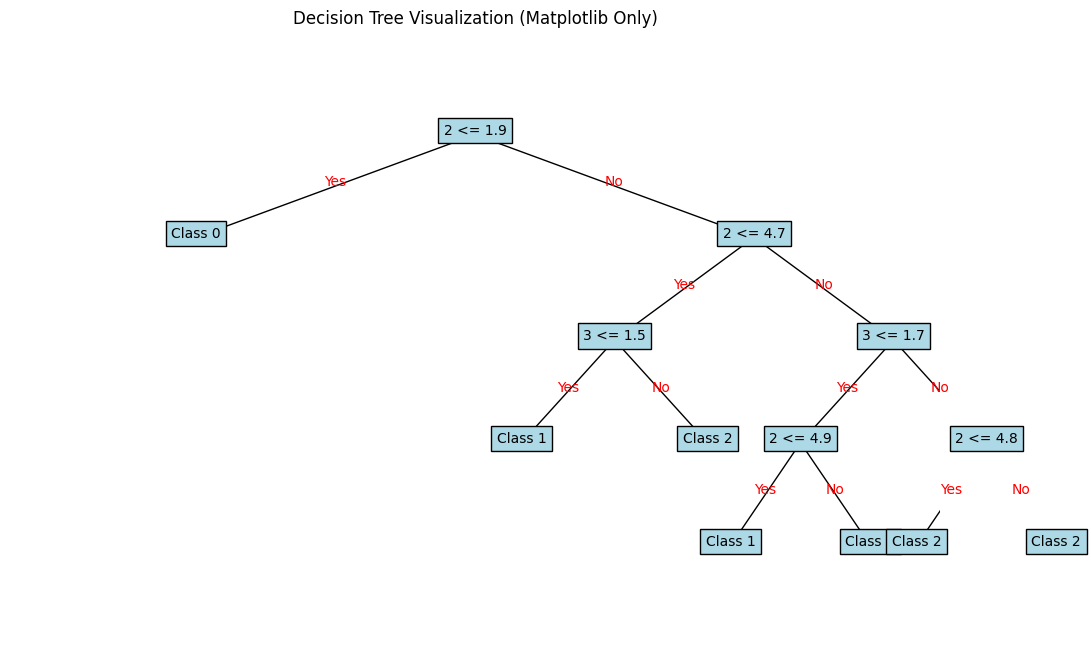

In [34]:
import matplotlib.pyplot as plt

def plot_tree(node, x=0, y=0, dx=6, dy=2, level=1, ax=None, parent=None, edge_label=""):
    """
    Recursively plots the decision tree using only Matplotlib.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.set_xlim(-10, 10)
        ax.set_ylim(-10, 2)
        ax.axis("off")  # Hide axis

    if node is None:
        return

    # Node label
    node_label = f"{node.feature} <= {node.value}" if node.feature else f"Class {node.results}"

    # Draw the current node
    ax.text(x, y, node_label, ha="center", bbox=dict(facecolor="lightblue", edgecolor="black"))

    if parent:
        ax.plot([parent[0], x], [parent[1], y], 'k-', lw=1)  # Draw edge
        ax.text((parent[0] + x) / 2, (parent[1] + y) / 2, edge_label, fontsize=10, ha="center", color="red")

    # Recursively add branches
    left_x, left_y = x - dx / level, y - dy
    right_x, right_y = x + dx / level, y - dy

    if node.true_branch:
        plot_tree(node.true_branch, left_x, left_y, dx, dy, level + 1, ax, (x, y), "Yes")

    if node.false_branch:
        plot_tree(node.false_branch, right_x, right_y, dx, dy, level + 1, ax, (x, y), "No")

def visualize_tree(root_node):
    """
    Generates and plots the decision tree using Matplotlib.
    """
    plot_tree(root_node)
    plt.title("Decision Tree Visualization (Matplotlib Only)")
    plt.show()

# Call the function with your root node
visualize_tree(decision_tree)


In [35]:
pred=predict(decision_tree, X_test[0])

In [36]:
pred

1

In [37]:
y_test[0]

1

In [38]:
pred=[]
for i in X_test:
    pred.append(predict(decision_tree, i))

In [39]:
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score,recall_score,precision_score

In [40]:
f1_score(y_test, pred, average='macro')

0.9484126984126983

In [41]:
precision_score(y_test, pred, average='macro')

0.9555555555555556

In [42]:
confusion_matrix(y_test, pred)

array([[19,  0,  0],
       [ 0, 11,  2],
       [ 0,  0, 13]])

Implement Cart Algorithm
- there deciding parameter is gini index

In [43]:
def gini(data):
    counts = np.bincount(data)
    probabilities = counts / len(data)
    gini = 1 - np.sum(probabilities**2)
    return gini

In [44]:
def build_tree(X, y, max_depth=None, current_depth=0):  # Add max_depth and current_depth parameters
    y = y.ravel()
    if len(set(y)) == 1 or (max_depth is not None and current_depth >= max_depth): # Check for max_depth condition
        return Node(results=y[0])

    best_gini = 1  # Initialize with the maximum possible Gini impurity
    best_criteria = None
    best_sets = None
    n_features = X.shape[1]

    current_gini = gini(y)

    for feature in range(n_features):
        feature_values = set(X[:, feature])
        for value in feature_values:
            true_X, true_y, false_X, false_y = split_data(X, y, feature, value)
            p = len(true_y) / len(y)
            gini_split = p * gini(true_y) + (1 - p) * gini(false_y)

            if gini_split < best_gini:
                best_gini = gini_split
                best_criteria = (feature, value)
                best_sets = (true_X, true_y, false_X, false_y)

    if best_gini < current_gini:
        true_branch = build_tree(best_sets[0], best_sets[1], max_depth, current_depth + 1)  # Increment current_depth
        false_branch = build_tree(best_sets[2], best_sets[3], max_depth, current_depth + 1) # Increment current_depth
        return Node(feature=best_criteria[0], value=best_criteria[1], true_branch=true_branch, false_branch=false_branch)

    return Node(results=y[0])

In [45]:
cart_tree=build_tree(X_train, y_train, max_depth=3)

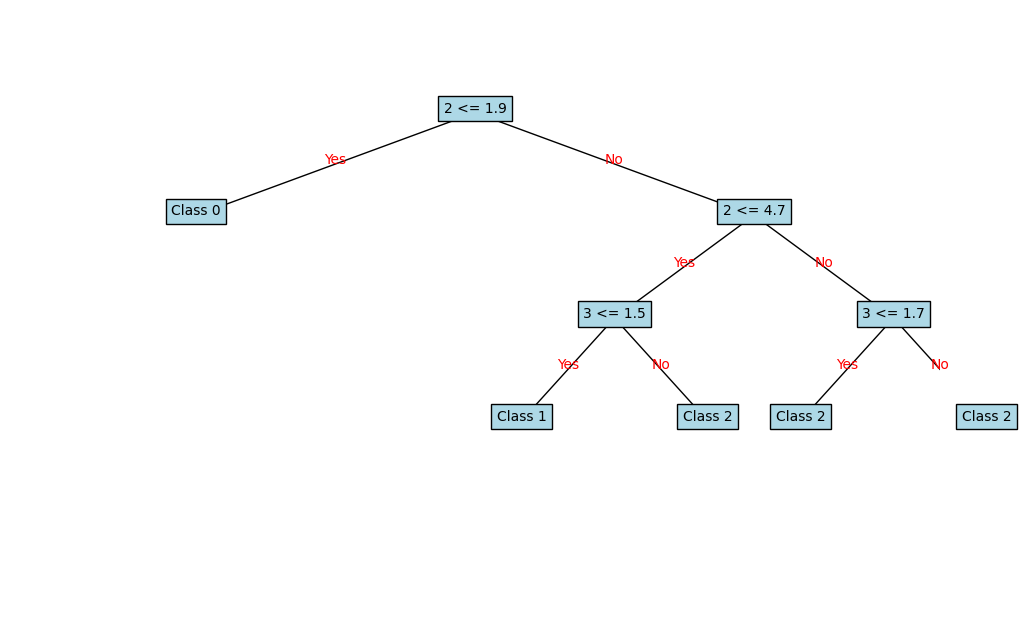

In [46]:
plot_tree(cart_tree)

In [47]:
cart_pred=[]
for i in X_test:
    cart_pred.append(predict(cart_tree, i))

In [48]:
confusion_matrix(y_test, pred)

array([[19,  0,  0],
       [ 0, 11,  2],
       [ 0,  0, 13]])

In [49]:
precision_score(cart_pred, y_test, average='macro')

0.923076923076923

In [50]:
accuracy_score(cart_pred, y_test)

0.9333333333333333

In [51]:
recall_score(cart_pred, y_test, average='macro')

0.9375

The performance of both algorithms almost same with this dataset .
- max depth of the tree matters alot role in the overfitting and underfitting situation .
- i set it to 4 to get generalized results.

# ***Question no. 2***

---



In [104]:
class AdaBoost:
    def __init__(self, n_estimators=50):
        self.n_estimators = n_estimators
        self.alphas = []
        self.models = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        w = np.ones(n_samples) / n_samples
        for _ in range(self.n_estimators):
            # Use the existing build_tree function
            model = build_tree(X, y,max_depth=4) # Use X, y instead of X_train, y_train here
            predictions = np.array([predict(model, x) for x in X])
            err = np.sum(w * (predictions != y)) / np.sum(w)
            alpha = 0.5 * np.log((1 - err) / (err + 1e-10))
            self.alphas.append(alpha)
            self.models.append(model)
            print(self.alphas)
            print(self.models)
            w = w * np.exp(-alpha * y * predictions)
            w = w / np.sum(w)

    def predict(self, X):
        n_samples = X.shape[0]
        y_pred = np.zeros(n_samples)
        for alpha, model in zip(self.alphas, self.models):
            predictions = np.array([predict(model, x) for x in X])
            y_pred += alpha * predictions
        return np.sign(y_pred)




In [105]:
adaboost = AdaBoost(n_estimators=20)

# Train the classifier
adaboost.fit(X_train, y_train)

# Make predictions on the test set
y_pred_adaboost = adaboost.predict(X_test)


# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred_adaboost)
print("Accuracy:", accuracy)

[1.7631802605580804]
[1.7631802605580804, 3.0174777057919058]
[<__main__.Node object at 0x7f251c412810>, <__main__.Node object at 0x7f251c648d50>]
[1.7631802605580804, 3.0174777057919058, 5.952918207386976]
[<__main__.Node object at 0x7f251c412810>, <__main__.Node object at 0x7f251c648d50>, <__main__.Node object at 0x7f251cd86c90>]
[1.7631802605580804, 3.0174777057919058, 5.952918207386976, 11.32373425535788]
[<__main__.Node object at 0x7f251c412810>, <__main__.Node object at 0x7f251c648d50>, <__main__.Node object at 0x7f251cd86c90>, <__main__.Node object at 0x7f251cdcc910>]
[1.7631802605580804, 3.0174777057919058, 5.952918207386976, 11.32373425535788, 11.512925464936655]
[<__main__.Node object at 0x7f251c412810>, <__main__.Node object at 0x7f251c648d50>, <__main__.Node object at 0x7f251cd86c90>, <__main__.Node object at 0x7f251cdcc910>, <__main__.Node object at 0x7f251c18c110>]
[1.7631802605580804, 3.0174777057919058, 5.952918207386976, 11.32373425535788, 11.512925464936655, 11.512925